In [ ]:
import json
from glob import glob as gglob
from os.path import join as joiner
from os import makedirs
from skimage.transform import resize
from pathlib import Path 
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np

In [ ]:
###############################
# misc
###############################

def open_json(file):
    with open(file) as f:
        d = json.load(f)
    return d

def save_dict(dct, file):
    with open(file, 'w', encoding='utf-8') as f:
        json.dump(dct, f, indent=2)

In [ ]:
###############################
# labelme2mask
###############################

from PIL import Image, ImageDraw

def labelme2mask(data):

    TARGET_LIST = ['graffiti', 'protective equipment', 'spalling', 'hollowareas', 'weathering', 'drainage', 'efflorescence',
                'rust', 'restformwork', 'wetspot', 'crack', 'washouts/concrete corrosion', 'joint tape',
                'rockpocket', 'bearing', 'cavity', 'alligator crack', 'exposed rebars', 'expansion joint']

    if isinstance(data, str):
        with open(data, 'r') as f:
            data = json.load(f)
    assert type(data) == dict

    target_dict = dict(zip(TARGET_LIST, range(len(TARGET_LIST))))
    height = data["size"]["height"]
    width = data["size"]["width"]
    target_mask = np.zeros((height, width, len(TARGET_LIST)))
    for obj in data["objects"]:
        label = obj["classTitle"]
        if label in TARGET_LIST:
            # Get the target index (channel) for this label
            target_index = target_dict[label]

            # Create an empty mask for the current object
            target_img = Image.new('L', (width, height), 0)

            # Get the exterior polygon points from the "points" field
            polygon = [(x, y) for x, y in obj["points"]["exterior"]]  # Convert list to tuple

            # Draw the polygon on the mask
            ImageDraw.Draw(target_img).polygon(polygon, outline=1, fill=1)

            # Add the polygon mask to the appropriate channel in the target mask
            target_mask[:, :, target_index] += np.array(target_img)
    return target_mask.astype(bool).astype(np.uint8)

In [ ]:
# resize images

def resize_images(source_folder, target_folder, size=(256,256)):
    """Resize all images in `source_folder` to size `size` and store it in `target_folder`"""
    image_files = sorted(gglob(joiner(source_folder, "*.jpg")))
    makedirs(target_folder, exist_ok = True)
    
    for image_filename in tqdm(image_files):
        base_filename = Path(image_filename).name
        target_name = joiner(target_folder, base_filename)
        with Image.open(image_filename) as img:
            img = img.resize(size)
            img = img.save(target_name)
    print(f"Resized images saved in {target_folder}")

In [ ]:
# resize annotations

def _resize_annotation_data(data, width_factor, height_factor):
    w_index, h_index = 0, 1
    
    # Iterate through all objects
    for obj in data["objects"]:
        # If the object has an exterior polygon (points)
        if "points" in obj and "exterior" in obj["points"]:
            # Get the length of points in the "exterior" polygon
            point_len = len(obj["points"]["exterior"])
            
            # Loop through each point in the polygon
            for point_idx in range(point_len):
                the_w = obj["points"]["exterior"][point_idx][w_index]
                the_h = obj["points"]["exterior"][point_idx][h_index]

                # Apply the resizing factors
                obj["points"]["exterior"][point_idx][w_index] = the_w / width_factor
                obj["points"]["exterior"][point_idx][h_index] = the_h / height_factor
                
    return data

def resize_annotations(source_folder, target_folder, size=(256,256)):
    """Resize all labelme annotations (all polygone points and imageWiedth and imageHeight) 
        in `source_folder` to size `size` and store it in `target_folder`"""
    annotation_files = sorted(gglob(joiner(source_folder, "*.json")))
    makedirs(target_folder, exist_ok = True)

    for annotation_filename in tqdm(annotation_files):
        data = open_json(annotation_filename)
        filename = Path(annotation_filename).name
        target_filename = joiner(target_folder, filename)
        
        width_factor = data["size"]["width"] / size[0]
        height_factor = data["size"]["height"] / size[1]

        data = _resize_annotation_data(data, width_factor, height_factor)
        data["size"]["width"] = size[0]
        data["size"]["height"] = size[1]
        save_dict(data, target_filename)
    print(f"Resized annotations saved in {target_folder}")

In [ ]:
# Filtering and Normalizing images

import numpy as np
import cv2
from tqdm import tqdm 
import os
from glob import glob

def filtering_normalizing(input_folder, output_folder):
    for image_path in tqdm(glob(os.path.join(input_folder, "*.jpg"))):
        # Load image
        img = cv2.imread(image_path)

        # Step 1: Noise filtering using Gaussian Blur
        denoised_img = cv2.GaussianBlur(img, (5, 5), 0)

        # Step 2: Normalize the image to range [0, 1] (min-max normalization)
        normalized_img = denoised_img / 255.0

        # Step 3: Save the processed image
        # Optional: Convert back to uint8 if needed
        output_image_path = os.path.join(output_folder, os.path.basename(image_path))
        normalized_uint8_img = np.uint8(normalized_img * 255)  # Convert back to [0, 255] range for saving
        cv2.imwrite(output_image_path, normalized_uint8_img)

    print(f"Images Processed and saved in {output_folder}")

In [ ]:
import os
from glob import glob

# Paths
source_image_folder1 = "/kaggle/input/dacl10k/train/train/img"  # Original training images folder
source_image_folder2 = "/kaggle/input/dacl10k/test/test/img"  # Original testing images folder
resize_image_folder1 = "/kaggle/working/target_folder/train/img"   # Resized training images output folder
resize_image_folder2 = "/kaggle/working/target_folder/test/img"   # Resized testing images output folder
source_annotation_folder1 = "/kaggle/input/dacl10k/train/train/ann"  # Original train annotations (LabelMe JSONs) folder
source_annotation_folder2 = "/kaggle/input/dacl10k/test/test/ann"  # Original test annotations (LabelMe JSONs) folder
resize_annotation_folder1 = "/kaggle/working/target_folder/train/ann"   # Resized train annotations output folder
resize_annotation_folder2 = "/kaggle/working/target_folder/test/ann"   # Resized test annotations output folder
filtered_image_folder1 = "/kaggle/working/filtered/train" # Filtered and Normalized train images folder
filtered_image_folder2 = "/kaggle/working/filtered/test" # Filtered and Normalized test images folder
mask_output_folder1 = "/kaggle/working/mask/train"  # Folder where train masks will be saved
mask_output_folder2 = "/kaggle/working/mask/test"  # Folder where test masks will be saved

# Step 1: Resize images
resize_images(source_folder=source_image_folder1, target_folder=resize_image_folder1, size=(256, 256))
resize_images(source_folder=source_image_folder2, target_folder=resize_image_folder2, size=(256, 256))

# Step 2: Resize annotations
resize_annotations(source_folder=source_annotation_folder1, target_folder=resize_annotation_folder1, size=(256, 256))
resize_annotations(source_folder=source_annotation_folder2, target_folder=resize_annotation_folder2, size=(256, 256))

# Step 3: Filtering and Normalizing images 
os.makedirs(filtered_image_folder1, exist_ok=True)
os.makedirs(filtered_image_folder2, exist_ok=True)
filtering_normalizing(resize_image_folder1, filtered_image_folder1)
filtering_normalizing(resize_image_folder2, filtered_image_folder2)

In [ ]:
# Step 4: Convert resized annotations to multi-channel masks
os.makedirs(mask_output_folder1, exist_ok=True)  # Ensure the mask output folder exists
os.makedirs(mask_output_folder2, exist_ok=True)

annotation_files1 = glob(os.path.join(resize_annotation_folder1, "*.json"))
annotation_files2 = glob(os.path.join(resize_annotation_folder2, "*.json"))

for annotation_file in tqdm(annotation_files1):
    # Convert each resized annotation to a multi-channel mask
    annotation_data = open_json(annotation_file)  # Load annotation
    mask = labelme2mask(annotation_data)  # Convert to mask

    # Save the mask as a NumPy array (.npy) or any other format like PNG
    mask_filename = os.path.splitext(os.path.basename(annotation_file))[0] + "_mask.npz"
    mask_output_path = os.path.join(mask_output_folder1, mask_filename)

    np.savez_compressed(mask_output_path, mask)  # Save the mask
print(f"Saved mask for annotation_files in {mask_output_folder1}")

for annotation_file in tqdm(annotation_files2):
    # Convert each resized annotation to a multi-channel mask
    annotation_data = open_json(annotation_file)  # Load annotation
    mask = labelme2mask(annotation_data)  # Convert to mask

    # Save the mask as a NumPy array (.npy) or any other format like PNG
    mask_filename = os.path.splitext(os.path.basename(annotation_file))[0] + "_mask.npz"
    mask_output_path = os.path.join(mask_output_folder2, mask_filename)

    np.savez_compressed(mask_output_path, mask)  # Save the mask
print(f"Saved mask for annotation_file in {mask_output_folder2}")

In [1]:
import numpy as np
mask_data = np.load("/kaggle/working/mask/train/dacl10k_v2_train_0000.jpg_mask.npz", allow_pickle=True)
mask_array = mask_data['arr_0']

# Print details about the array
print("Array shape:", mask_array.shape)
print("Array dtype:", mask_array.dtype)
print("Unique values:", np.unique(mask_array))

Array shape: (256, 256, 19)
Array dtype: uint8
Unique values: [0 1]


In [2]:
mask_array[:,:,0].shape

(256, 256)

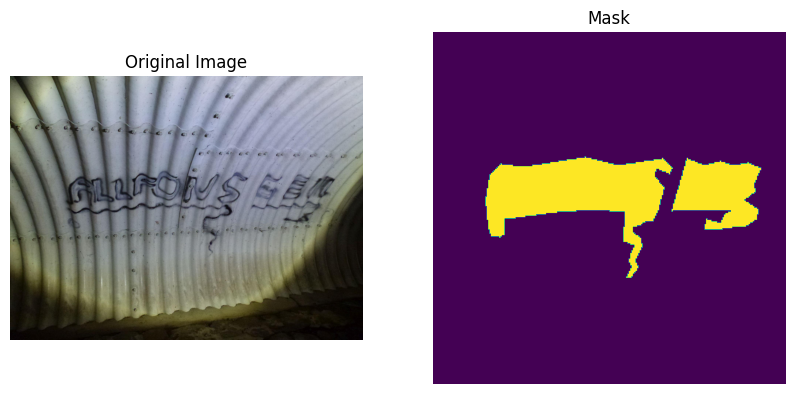

In [3]:
import cv2
import matplotlib.pyplot as plt

# Load the original image using OpenCV
image_path = "/kaggle/input/dacl10k/train/train/img/dacl10k_v2_train_0000.jpg"  
image_array = cv2.imread(image_path)
image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(image_array)
plt.title("Original Image")
plt.axis("off")

# Display the mask
plt.subplot(1, 2, 2)
plt.imshow(mask_array[:, :, 0])  # Show the first channel of the mask
plt.title("Mask")
plt.axis("off")

plt.show()

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
#         super(ConvBlock, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, 
#                               padding=padding, stride=stride)
#         self.bn = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
        
#     def forward(self, x):
#         x = self.conv(x)
#         x = self.bn(x)
#         x = self.relu(x)
#         return x

# class PyramidPoolingModule(nn.Module):
#     def __init__(self, in_channels, pool_sizes=[1, 2, 3, 6]):
#         super(PyramidPoolingModule, self).__init__()
#         self.stages = nn.ModuleList([self._make_stage(in_channels, pool_size, len(pool_sizes)) for pool_size in pool_sizes])
        
#     def _make_stage(self, in_channels, pool_size, num_stages):
#         return nn.Sequential(
#             nn.AdaptiveAvgPool2d(pool_size),
#             nn.Conv2d(in_channels, in_channels // num_stages, kernel_size=1, bias=False),  # Dividing by the number of stages
#             nn.BatchNorm2d(in_channels // num_stages),
#             nn.ReLU(inplace=True)
#         )
        
#     def forward(self, x):
#         h, w = x.size(2), x.size(3)
#         pyramids = [F.interpolate(stage(x), size=(h, w), mode='bilinear', align_corners=True) for stage in self.stages]
#         output = torch.cat(pyramids + [x], dim=1)
#         return output


# class BridgeDamageDetectionCNN(nn.Module):
#     def __init__(self, num_classes=19):  # 19 damage classes
#         super(BridgeDamageDetectionCNN, self).__init__()
        
#         # Initial Conv Layers
#         self.conv1 = ConvBlock(3, 64)   # Input 3 channels (RGB)
#         self.conv2 = ConvBlock(64, 128)
#         self.conv3 = ConvBlock(128, 256)
#         self.conv4 = ConvBlock(256, 512)
        
#         # Pyramid Pooling Module
#         self.pyramid_pooling = PyramidPoolingModule(512)
        
#         # Feature Fusion layers
#         self.conv5 = ConvBlock(1024, 512)  # After pyramid fusion, double the number of channels
#         self.conv6 = ConvBlock(512, 256)
#         self.conv7 = ConvBlock(256, 128)
        
#         # Output Segmentation Layer
#         self.output_layer = nn.Conv2d(128, num_classes, kernel_size=1)
        
#     def forward(self, x):
#         x = self.conv1(x)   # 64 channels
#         x = self.conv2(x)   # 128 channels
#         x = self.conv3(x)   # 256 channels
#         x = self.conv4(x)   # 512 channels
        
#         # Pyramid Pooling
#         x = self.pyramid_pooling(x)  # 1024 channels after pyramid pooling fusion
        
#         # Feature Fusion
#         x = self.conv5(x)   # 512 channels
#         x = self.conv6(x)   # 256 channels
#         x = self.conv7(x)   # 128 channels
        
#         # Output Layer
#         x = self.output_layer(x)  # Output num_classes channels
        
#         return x

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.layers import (Conv2D, UpSampling2D, Input, Add, GlobalAveragePooling2D, Dropout, 
#                                     Dense, BatchNormalization)
# from tensorflow.keras.applications import EfficientNetB4 
# from tensorflow.keras.models import Model

# def FPN(input_shape=(256, 256, 3), num_classes=19):
#     # Load EfficientNetB4 as the backbone
#     backbone = EfficientNetB4(weights="imagenet", include_top=False, input_shape=input_shape)

#     # Extract features from the backbone
#     c1 = backbone.get_layer("block1b_add").output  
#     c2 = backbone.get_layer("block2b_add").output 
#     c3 = backbone.get_layer("block3d_add").output  
#     c4 = backbone.get_layer("block4f_add").output  
#     c5 = backbone.get_layer("block6d_add").output  

#     # ASPP layers
#     aspp5 = Conv2D(256, kernel_size=1, padding='same', dilation_rate=1)(c5)
#     aspp5 = BatchNormalization()(aspp5)
#     aspp6 = Conv2D(256, kernel_size=3, padding='same', dilation_rate=6)(c5)
#     aspp6 = BatchNormalization()(aspp6)
#     aspp7 = Conv2D(256, kernel_size=3, padding='same', dilation_rate=12)(c5)
#     aspp7 = BatchNormalization()(aspp7)
#     aspp8 = Conv2D(256, kernel_size=3, padding='same', dilation_rate=18)(c5)
#     aspp8 = BatchNormalization()(aspp8)

#     aspp_output = tf.keras.layers.Concatenate()([aspp5, aspp6, aspp7, aspp8])
#     aspp_output = Conv2D(256, kernel_size=1, padding='same', activation='relu')(aspp_output)

#     # Auxiliary classification head
#     aux_output = GlobalAveragePooling2D()(aspp_output)
#     aux_output = Dropout(0.5)(aux_output)
#     aux_output = Dense(num_classes, activation='softmax', name='aux_output')(aux_output)

#     # Upsampling and skip connections
#     p5 = UpSampling2D(size=(2, 2))(aspp_output)  
#     p5 = Conv2D(256, kernel_size=3, padding='same', activation='relu')(p5)
#     p5 = BatchNormalization()(p5)

#     p4 = UpSampling2D(size=(2, 2))(p5) 
#     p4 = Add()([p4, Conv2D(256, kernel_size=1, padding='same')(c3)]) 
#     p4 = Conv2D(256, kernel_size=3, padding='same', activation='relu')(p4)
#     p4 = BatchNormalization()(p4)

#     p3 = UpSampling2D(size=(2, 2))(p4)  
#     p3 = Add()([p3, Conv2D(256, kernel_size=1, padding='same')(c2)])  
#     p3 = Conv2D(256, kernel_size=3, padding='same', activation='relu')(p3)
#     p3 = BatchNormalization()(p3)

#     p2 = UpSampling2D(size=(2, 2))(p3)  
#     p2 = Add()([p2, Conv2D(256, kernel_size=1, padding='same')(c1)]) 
#     p2 = Conv2D(256, kernel_size=3, padding='same', activation='relu')(p2)
#     p2 = UpSampling2D(size=(2, 2))(p2)
    
#     # Final output layer
#     output = Conv2D(num_classes, kernel_size=1, activation='softmax', name='main_output')(p2)

#     model = Model(inputs=backbone.input, outputs=[output, aux_output])
#     return model

# # Create the model with the desired input and output shapes
# model = FPN(input_shape=(256, 256, 3), num_classes=19)
# #model.summary()

In [4]:
%env SM_FRAMEWORK=tf.keras
!pip install segmentation_models
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.9 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


In [5]:
import tensorflow as tf
from segmentation_models import Unet, FPN
from tensorflow.keras.applications import efficientnet, resnet

backbones = {
    "EfficientNet-B2": "efficientnetb2",
    "EfficientNet-B4": "efficientnetb4",
    "ResNet101":"resnet101"
}

def create_model(architecture, backbone, input_shape=(256, 256, 3), num_classes=19):
     # Base segmentation model
    preprocess_input = sm.get_preprocessing(backbone)
    if architecture == "FPN":
        model = FPN(backbone_name=backbone, input_shape=input_shape, classes=num_classes, activation='softmax')
    elif architecture == "Unet":
        model = Unet(backbone_name=backbone, input_shape=input_shape, classes=num_classes, activation='softmax')
    else:
        raise ValueError("Unsupported architecture. Choose 'FPN' or 'Unet'.")

    # Auxiliary Classification Head
    encoder_output = model.layers[-1].output
    aux_output = tf.keras.layers.GlobalAveragePooling2D()(encoder_output)
    aux_output = tf.keras.layers.Dropout(0.3)(aux_output)
    aux_output = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='aux_output')(aux_output)
    
    return model, preprocess_input

In [3]:
models = {}
input_shape = (256, 256, 3)
num_classes = 19

for backbone_name, backbone in backbones.items():
    for architecture in ["FPN", "Unet"]: 
        model, preprocess_input = create_model(architecture, backbone, input_shape=input_shape, num_classes=num_classes)
        models[f"{architecture}_{backbone_name}"] = model

        # Summary of the model architecture
        print(f"\nModel: {architecture} with {backbone_name}")
        # model.summary()


Model: FPN with EfficientNet-B2

Model: Unet with EfficientNet-B2

Model: FPN with EfficientNet-B4

Model: Unet with EfficientNet-B4

Model: FPN with ResNet101

Model: Unet with ResNet101


In [4]:
# Define combined Dice and Cross-Entropy Loss for auxiliary training
from segmentation_models.losses import DiceLoss
import tensorflow as tf

class CombinedLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
        self.dice_loss = DiceLoss()
        self.ce_loss = tf.keras.losses.CategoricalCrossentropy()

    def call(self, y_true, y_pred, aux_true=None, aux_pred=None):
        mask_loss = self.dice_loss(y_true, y_pred)
        aux_loss = self.ce_loss(aux_true, aux_pred) if aux_true is not None and aux_pred is not None else 0
        return mask_loss + 0.1 * aux_loss

In [5]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm

def Data_generator(image_folder, mask_folder):
    train_images = []
    train_masks = []

    # Load images
    image_files = sorted(glob(os.path.join(image_folder, "*.jpg")))
    mask_files = sorted(glob(os.path.join(mask_folder, "*.npz")))
    
    print(len(image_files))
    print(len(mask_files))

    # Ensure matching numbers of images and masks
    if len(image_files) != len(mask_files):
        raise ValueError("The number of images and masks must be the same.")

    for img_path, mask_path in tqdm(zip(image_files, mask_files), total=len(image_files)):
        # Load and preprocess image
        image = cv2.imread(img_path)
        train_images.append(image)

        # Load and preprocess mask
        mask_data = np.load(mask_path, allow_pickle=True)
        mask = mask_data['arr_0']
        train_masks.append(mask)

    return np.array(train_images), np.array(train_masks)

# Define your directories
train_image_folder = "/kaggle/working/filtered/train"
train_mask_folder = "/kaggle/working/mask/train"

# Load the training data
train_images, train_masks = Data_generator(train_image_folder, train_mask_folder)

# Check the shapes of the loaded data
print("Training images shape:", train_images.shape)
print("Training masks shape:", train_masks.shape)

6935
6935


100%|██████████| 6935/6935 [00:30<00:00, 226.70it/s]


Training images shape: (6935, 256, 256, 3)
Training masks shape: (6935, 256, 256, 19)


In [6]:
architecture = "FPN"
backbone = "efficientnetb4"

model, preprocess_input = create_model(architecture, backbone, input_shape=input_shape, num_classes=num_classes)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanIoU

# Compile model with an appropriate optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
combined_loss = CombinedLoss()
model.compile(optimizer=optimizer, loss=combined_loss, metrics=["accuracy", MeanIoU(num_classes=19)])

# Use data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size = 16

# Create data generators
train_generator = datagen.flow(train_images, train_masks, batch_size=batch_size)

# Callbacks for monitoring
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Training the model
history = model.fit(train_generator, steps_per_epoch=len(train_images) // batch_size, epochs=20, callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 644s 1s/step - accuracy: 0.1419 - loss: 0.9237 - mean_io_u_1: 0.2678
Epoch 2/20


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,mean_io_u_1
  current = self.get_monitor_value(logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 253us/step - accuracy: 0.0729 - loss: 0.9209 - mean_io_u_1: 0.4922  
Epoch 3/20


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


433/433 ━━━━━━━━━━━━━━━━━━━━ 360s 708ms/step - accuracy: 0.1382 - loss: 0.8766 - mean_io_u_1: 0.2821
Epoch 4/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 104us/step - accuracy: 0.1512 - loss: 0.8413 - mean_io_u_1: 0.4966  
Epoch 5/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 308s 707ms/step - accuracy: 0.1418 - loss: 0.8585 - mean_io_u_1: 0.2954
Epoch 6/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 111us/step - accuracy: 0.1602 - loss: 0.8476 - mean_io_u_1: 0.5072  
Epoch 7/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 308s 706ms/step - accuracy: 0.1478 - loss: 0.8431 - mean_io_u_1: 0.3069
Epoch 8/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 118us/step - accuracy: 0.1281 - loss: 0.8649 - mean_io_u_1: 0.5005  
Epoch 9/20
  4/433 ━━━━━━━━━━━━━━━━━━━━ 6:01 843ms/step - accuracy: 0.1256 - loss: 0.8404 - mean_io_u_1: 0.4859

In [ ]:
test_image_folder = "/kaggle/working/filtered/test"
test_mask_folder = "/kaggle/working/mask/test"

# Load the testing data
test_images, test_masks = Data_generator(test_image_folder, test_mask_folder)

# Check the shapes of the loaded data
print("Training images shape:", test_images.shape)
print("Training masks shape:", test_masks.shape)

In [ ]:
# Function to load a batch of test data
def load_test_batch(image_folder, mask_folder, start, batch_size):
    images = []
    masks = []
    for i in range(start, start + batch_size):
        # Load images and masks from their respective folders
        # Assuming your `Data_generator` can load a specific image by index
        img, mask = Data_generator(test_image_folder, test_mask_folder)  # Adjust if needed
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

# Initialize accumulators for IoU and other metrics
mean_iou = []
mean_accuracy = []

# Loop through test data in batches
for start in range(0, len(test_images), batch_size):
    # Load a batch of test data
    images_batch, masks_batch = load_test_batch(test_image_folder, test_mask_folder, start, batch_size)
    
    # Run predictions
    predictions = model.predict(images_batch)
    
    # Evaluate the model on this batch
    batch_loss, batch_accuracy, batch_iou = model.evaluate(images_batch, masks_batch, verbose=0)
    
    # Store the metrics
    mean_iou.append(batch_iou)
    mean_accuracy.append(batch_accuracy)

# Calculate overall mean IoU and accuracy
overall_iou = np.mean(mean_iou)
overall_accuracy = np.mean(mean_accuracy)

print(f'Test Mean IoU: {overall_iou}')
print(f'Test Mean Accuracy: {overall_accuracy}')

In [ ]:
# plot the training and training loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
#plt.axhline(y=test_loss, color='r', linestyle='-', label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()